In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 638.8849, train_label_loss: 2.8052, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 12410.7746, train_label_loss: 2.7054, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 12477.7611, train_label_loss: 2.5594, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 12507.5450, train_label_loss: 2.4400, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 12500.2478, train_label_loss: 2.3068, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 12519.8975, train_label_loss: 2.1522, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 12469.0691, train_label_loss: 1.9630, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 12374.6498, train_label_loss: 1.8902, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10671.4504, train_label_loss: 1.7401, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10684.4296, train_label_loss: 1.5568, 


epoch: 1, source_val_acc_label: 0.6175, source_val_label_loss: 1.4692, target_val_acc_label: 0.6175, target_val_label_loss: 1.4692, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 49.6406, train_label_loss: 1.4490, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10658.9987, train_label_loss: 1.4525, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10737.2649, train_label_loss: 1.2651, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10751.4473, train_label_loss: 1.3906, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10601.3529, train_label_loss: 1.1440, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10702.7536, train_label_loss: 0.9473, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10628.8732, train_label_loss: 1.1333, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10640.4307, train_label_loss: 0.8480, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10656.5110, train_label_loss: 0.7341, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10664.0587, train_label_loss: 0.8711, 


epoch: 2, source_val_acc_label: 0.8385, source_val_label_loss: 0.7015, target_val_acc_label: 0.8385, target_val_label_loss: 0.7015, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 55.2529, train_label_loss: 0.7662, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10522.7882, train_label_loss: 0.7662, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10552.9452, train_label_loss: 0.8644, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10712.4475, train_label_loss: 0.5309, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10572.8027, train_label_loss: 0.5222, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 10607.7671, train_label_loss: 0.5421, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 10716.4721, train_label_loss: 0.5236, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 10704.8632, train_label_loss: 0.4401, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 10599.8668, train_label_loss: 0.4452, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 10703.3449, train_label_loss: 0.4968, 


epoch: 3, source_val_acc_label: 0.9119, source_val_label_loss: 0.3840, target_val_acc_label: 0.9119, target_val_label_loss: 0.3840, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 56.2092, train_label_loss: 0.3476, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10612.0465, train_label_loss: 0.3561, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10626.4598, train_label_loss: 0.4926, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10711.5895, train_label_loss: 0.4261, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10660.4241, train_label_loss: 0.2987, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10484.3646, train_label_loss: 0.3537, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10621.3421, train_label_loss: 0.3087, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10658.8473, train_label_loss: 0.2723, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10708.8852, train_label_loss: 0.3937, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10757.9921, train_label_loss: 0.2934, 


epoch: 4, source_val_acc_label: 0.9296, source_val_label_loss: 0.4052, target_val_acc_label: 0.9296, target_val_label_loss: 0.4052, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 56.1249, train_label_loss: 0.3980, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10700.1218, train_label_loss: 0.3565, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10727.6408, train_label_loss: 0.2834, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10747.1721, train_label_loss: 0.3434, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10714.4068, train_label_loss: 0.1842, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10705.4502, train_label_loss: 0.2911, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10704.0461, train_label_loss: 0.2774, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10604.2022, train_label_loss: 0.1501, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10657.2166, train_label_loss: 0.2652, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10725.0813, train_label_loss: 0.2333, 


epoch: 5, source_val_acc_label: 0.9361, source_val_label_loss: 0.3642, target_val_acc_label: 0.9361, target_val_label_loss: 0.3642, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 57.3060, train_label_loss: 0.2470, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10627.8686, train_label_loss: 0.1830, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10776.7410, train_label_loss: 0.2387, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10732.9549, train_label_loss: 0.2315, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10738.6946, train_label_loss: 0.1472, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10684.1592, train_label_loss: 0.1959, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10694.2471, train_label_loss: 0.2359, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10770.1472, train_label_loss: 0.1785, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10767.8929, train_label_loss: 0.2763, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10675.8643, train_label_loss: 0.2109, 


epoch: 6, source_val_acc_label: 0.9466, source_val_label_loss: 0.3238, target_val_acc_label: 0.9466, target_val_label_loss: 0.3238, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 56.8058, train_label_loss: 0.1594, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10643.3494, train_label_loss: 0.1948, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10702.6804, train_label_loss: 0.1753, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10687.1854, train_label_loss: 0.1587, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10661.5658, train_label_loss: 0.1605, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10698.2931, train_label_loss: 0.1299, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10727.5948, train_label_loss: 0.2625, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10718.5933, train_label_loss: 0.2406, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10753.5532, train_label_loss: 0.3340, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10702.6027, train_label_loss: 0.1269, 


epoch: 7, source_val_acc_label: 0.9431, source_val_label_loss: 0.3092, target_val_acc_label: 0.9431, target_val_label_loss: 0.3092, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 56.9555, train_label_loss: 0.1584, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10540.3680, train_label_loss: 0.1418, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10782.2230, train_label_loss: 0.1733, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10699.5114, train_label_loss: 0.2120, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10610.6827, train_label_loss: 0.2540, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10729.0082, train_label_loss: 0.2578, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10666.0729, train_label_loss: 0.1708, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10758.1292, train_label_loss: 0.1484, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10665.8928, train_label_loss: 0.1489, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10718.9373, train_label_loss: 0.1627, 


epoch: 8, source_val_acc_label: 0.9520, source_val_label_loss: 0.2758, target_val_acc_label: 0.9520, target_val_label_loss: 0.2758, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 64.4644, train_label_loss: 0.2187, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11716.1500, train_label_loss: 0.2574, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11799.8849, train_label_loss: 0.0727, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11709.5209, train_label_loss: 0.1128, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11734.4161, train_label_loss: 0.1053, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11702.1411, train_label_loss: 0.1786, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11855.6649, train_label_loss: 0.1104, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11739.0108, train_label_loss: 0.1492, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11719.1608, train_label_loss: 0.1002, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11759.6622, train_label_loss: 0.1497, 


epoch: 9, source_val_acc_label: 0.9562, source_val_label_loss: 0.1750, target_val_acc_label: 0.9562, target_val_label_loss: 0.1750, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 64.9242, train_label_loss: 0.1069, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11692.9987, train_label_loss: 0.1698, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11752.1326, train_label_loss: 0.2227, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11722.8000, train_label_loss: 0.0981, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11663.0821, train_label_loss: 0.1643, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11676.5716, train_label_loss: 0.0908, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11691.8435, train_label_loss: 0.2002, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11730.0906, train_label_loss: 0.1131, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11675.0390, train_label_loss: 0.0928, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11729.2339, train_label_loss: 0.1329, 


epoch: 10, source_val_acc_label: 0.9593, source_val_label_loss: 0.2211, target_val_acc_label: 0.9593, target_val_label_loss: 0.2211, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 63.9702, train_label_loss: 0.1417, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11952.3018, train_label_loss: 0.1178, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11792.4907, train_label_loss: 0.1182, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11639.8761, train_label_loss: 0.1231, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11703.8011, train_label_loss: 0.1395, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11762.7687, train_label_loss: 0.1048, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11623.7508, train_label_loss: 0.2031, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11646.3601, train_label_loss: 0.1563, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11779.9488, train_label_loss: 0.1823, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11744.0640, train_label_loss: 0.1196, 


epoch: 11, source_val_acc_label: 0.9609, source_val_label_loss: 0.1459, target_val_acc_label: 0.9609, target_val_label_loss: 0.1459, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 64.0854, train_label_loss: 0.1133, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 11652.2361, train_label_loss: 0.1918, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11783.8308, train_label_loss: 0.1091, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11830.9570, train_label_loss: 0.1377, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 11733.0038, train_label_loss: 0.1448, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 11722.8877, train_label_loss: 0.0952, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11835.2399, train_label_loss: 0.1141, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11833.7324, train_label_loss: 0.1175, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11802.7144, train_label_loss: 0.0896, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 12523.5857, train_label_loss: 0.0677, 


epoch: 12, source_val_acc_label: 0.9579, source_val_label_loss: 0.2914, target_val_acc_label: 0.9579, target_val_label_loss: 0.2914, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 64.7036, train_label_loss: 0.1310, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11743.3743, train_label_loss: 0.1163, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11753.7499, train_label_loss: 0.1188, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11778.2966, train_label_loss: 0.1211, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11780.6670, train_label_loss: 0.1164, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11701.0863, train_label_loss: 0.0912, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 11710.0719, train_label_loss: 0.1108, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 11767.3874, train_label_loss: 0.1292, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 11770.1220, train_label_loss: 0.0610, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 11786.4881, train_label_loss: 0.0701, 


epoch: 13, source_val_acc_label: 0.9481, source_val_label_loss: 0.6644, target_val_acc_label: 0.9481, target_val_label_loss: 0.6644, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 66.0744, train_label_loss: 0.1493, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 11740.7876, train_label_loss: 0.0798, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 11653.5053, train_label_loss: 0.1154, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 11585.6107, train_label_loss: 0.0842, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 11804.8017, train_label_loss: 0.2062, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 11653.7510, train_label_loss: 0.0935, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 11746.0756, train_label_loss: 0.0754, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 11806.2387, train_label_loss: 0.0694, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 11723.0011, train_label_loss: 0.1240, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 11780.3568, train_label_loss: 0.1397, 


epoch: 14, source_val_acc_label: 0.9628, source_val_label_loss: 0.2421, target_val_acc_label: 0.9628, target_val_label_loss: 0.2421, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 63.5777, train_label_loss: 0.0795, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 11713.9247, train_label_loss: 0.0826, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 11821.0580, train_label_loss: 0.0493, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 11758.5289, train_label_loss: 0.1123, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 11809.5555, train_label_loss: 0.1365, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 11858.5398, train_label_loss: 0.1727, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 11776.1283, train_label_loss: 0.0802, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 11747.6581, train_label_loss: 0.0922, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 11723.2918, train_label_loss: 0.1062, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 11744.7981, train_label_loss: 0.0639, 


epoch: 15, source_val_acc_label: 0.9569, source_val_label_loss: 0.2587, target_val_acc_label: 0.9569, target_val_label_loss: 0.2587, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 65.7943, train_label_loss: 0.0794, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 11706.4660, train_label_loss: 0.0786, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 11851.6811, train_label_loss: 0.1169, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 11800.8557, train_label_loss: 0.0523, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 11789.9620, train_label_loss: 0.0997, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 11684.2770, train_label_loss: 0.0500, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 11726.0773, train_label_loss: 0.0490, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 11778.5993, train_label_loss: 0.0603, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 11748.7819, train_label_loss: 0.1111, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 11787.6267, train_label_loss: 0.1333, 


epoch: 16, source_val_acc_label: 0.9564, source_val_label_loss: 0.3568, target_val_acc_label: 0.9564, target_val_label_loss: 0.3568, 


epoch: 17, [batch: 1 / 1400], examples_per_second: 64.8421, train_label_loss: 0.1013, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 11769.2903, train_label_loss: 0.0706, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 11784.6456, train_label_loss: 0.1920, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 11765.8824, train_label_loss: 0.1238, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 11755.5441, train_label_loss: 0.0827, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 11735.6291, train_label_loss: 0.0615, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 11798.0512, train_label_loss: 0.1122, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 11738.8311, train_label_loss: 0.0781, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 11782.0428, train_label_loss: 0.0745, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 11733.7054, train_label_loss: 0.0616, 


epoch: 17, source_val_acc_label: 0.9626, source_val_label_loss: 0.1759, target_val_acc_label: 0.9626, target_val_label_loss: 0.1759, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 64.1773, train_label_loss: 0.0716, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 11787.7584, train_label_loss: 0.1290, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 11740.7766, train_label_loss: 0.0904, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 11800.1573, train_label_loss: 0.0768, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 11749.3568, train_label_loss: 0.0527, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 11717.1421, train_label_loss: 0.1580, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 11759.1967, train_label_loss: 0.0885, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 11774.8479, train_label_loss: 0.0869, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 11769.1710, train_label_loss: 0.1215, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 11723.9410, train_label_loss: 0.0713, 


epoch: 18, source_val_acc_label: 0.9621, source_val_label_loss: 0.2946, target_val_acc_label: 0.9621, target_val_label_loss: 0.2946, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

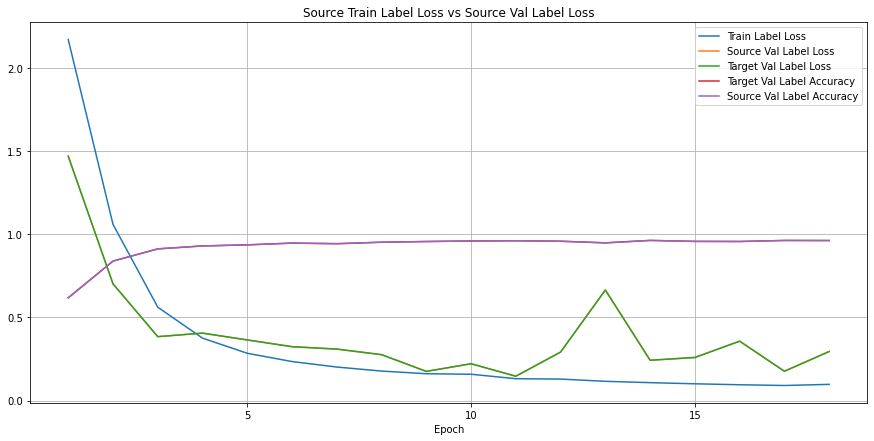

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

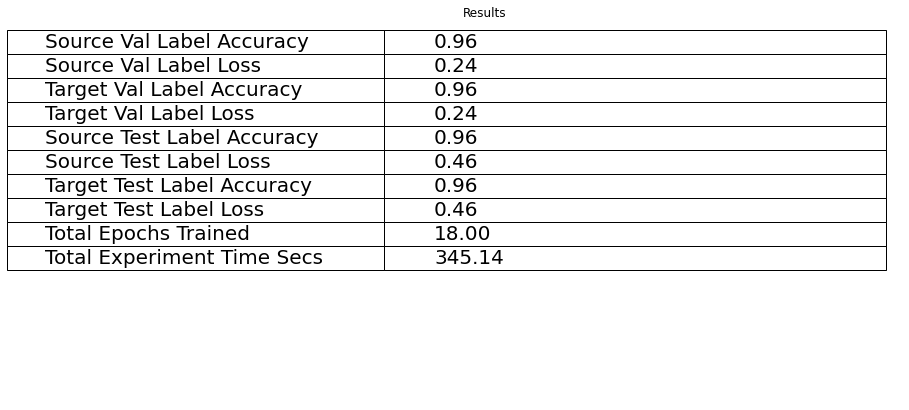

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

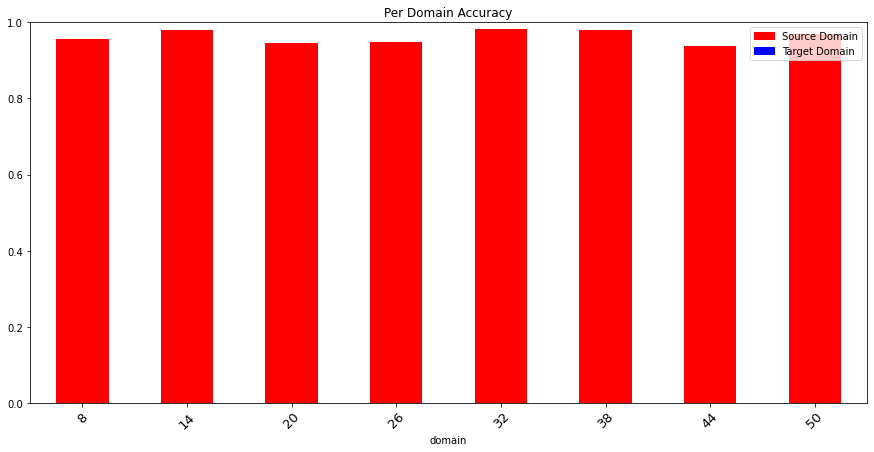

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9599739583333333 Target Test Label Accuracy: 0.9599739583333333
Source Val Label Accuracy: 0.9627604166666667 Target Val Label Accuracy: 0.9627604166666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch